### Importing Libraries

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc,confusion_matrix

### Load Input Dataset

In [75]:
# Loading dataset
data = pd.read_csv('input_file.csv',encoding='latin-1',low_memory=False)
data

,Control_Count,Date_Replied,Status,Unique_identifier,Likely_to_recommend_Online_Site_MY_SITE,Purchased_from_Site_A,Purchased_from_Site_B,Purchased_from_Site_C,Purchased_from_Site_D,Purchased_from_Site_E,...,Ease_of_business_online_system,Ease_of_business_overall_satisfaction,Improving_business_opps_knowledge_of_business,Improving_business_opps_understanding_of_needs,Improving_business_opps_demonstrating_opps,Improving_business_opps_specific_offers,Improving_business_opps_overall_satisfaction,Overall_Satisfaction_taking_everything_into_account,Proportion_of_purchase_made_with_MY_SITE,Future_proportion_of_purchase_made_at_MY_SITE
0,Day 1,19-08-2016,COMPLETED,711315000105288,10,NaN,1.0,1.0,NaN,NaN,...,8.0,8.0,8.0,7.0,8.0,7.0,6.0,8.0,76% to 99%,Increase
1,Day 1,19-08-2016,COMPLETED,391315000163276,7,NaN,1.0,NaN,1.0,NaN,...,8.0,8.0,8.0,10.0,9.0,7.0,8.0,9.0,26% to 50%,Increase
2,Day 1,19-08-2016,COMPLETED,501315000258371,6,NaN,1.0,1.0,NaN,NaN,...,8.0,6.0,99.0,99.0,99.0,99.0,99.0,6.0,DonÕt know,DonÕt know
3,Day 1,19-08-2016,COMPLETED,1001315000329142,7,NaN,1.0,1.0,1.0,NaN,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,6% to 15%,Stay the same
4,Day 1,19-08-2016,COMPLETED,101315000387196,7,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,10.0,10.0,10.0,10.0,9.0,9.0,51% to 75%,Increase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8455,NaN,42212,COMPLETE_Partial,1521116016789,2,1.0,NaN,NaN,NaN,1.0,...,2.0,4.0,6.0,4.0,9.0,2.0,2.0,4.0,16% to 25%,Increase
8456,NaN,42212,COMPLETED,1471116011769,8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8457,NaN,42212,COMPLETE_Partial,1031116036867,7,NaN,NaN,NaN,NaN,NaN,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN
8458,NaN,42213,COMPLETE_Partial,1691116029471,10,NaN,NaN,NaN,NaN,NaN,...,7.0,6.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,NaN


In [76]:
data.shape, len(pd.unique(data['Unique_identifier'])) # Checking shape of data and count of unique ID

((8460, 66), 8460)

### EDA

#### Checking coverage statistics of all the columns

In [77]:
def coverage_report(df):
    """
    coverage_report reports the counts and percentages of missing and non-missing records
    in all the columns of a Pandas DataFrame.

    :param df: A Pandas DataFrame containing the dataset for coverage analysis.
    :return: A Pandas DataFrame containing the coverage report.

    """
    df_coverage = df.isnull().sum().reset_index()
    df_coverage = df_coverage.rename(columns = {'index': 'column_name', 0: 'n_missing'})
    df_coverage['total'] = df.shape[0]
    df_coverage['n_non_missing'] = df_coverage['total'] - df_coverage['n_missing']
    df_coverage['pct_missing'] = (df_coverage['n_missing']/df_coverage['total']) * 100
    df_coverage['pct_non_missing'] = (df_coverage['n_non_missing']/df_coverage['total']) * 100
    df_coverage = df_coverage[['column_name', 'total', 'n_non_missing', 'n_missing', 'pct_non_missing', 'pct_missing']]
    return df_coverage

coverage_report(data)

,column_name,total,n_non_missing,n_missing,pct_non_missing,pct_missing
0,Control_Count,8460,5523,2937,65.283688,34.716312
1,Date_Replied,8460,8460,0,100.000000,0.000000
2,Status,8460,8460,0,100.000000,0.000000
3,Unique_identifier,8460,8460,0,100.000000,0.000000
4,Likely_to_recommend_Online_Site_MY_SITE,8460,8460,0,100.000000,0.000000
...,...,...,...,...,...,...
61,Improving_business_opps_specific_offers,8460,6732,1728,79.574468,20.425532
62,Improving_business_opps_overall_satisfaction,8460,6689,1771,79.066194,20.933806
63,Overall_Satisfaction_taking_everything_into_ac...,8460,6252,2208,73.900709,26.099291
64,Proportion_of_purchase_made_with_MY_SITE,8460,5798,2662,68.534279,31.465721


#### Checking distinct data points per column

In [78]:
def distinct_count_report(df):
    """
    distinct_count_report reports the count of distinct/unique values in all the columns of a Pandas DataFrame.

    :param df: A Pandas DataFrame containing the dataset for distinct count analysis.
    :return: A Pandas DataFrame containing the distinct count analysis report.
    """
    df_nunique = df.nunique().reset_index()
    df_nunique = df_nunique.rename(columns = {'index': 'column_name', 0: 'n_unique'})
    return df_nunique

distinct_count_report(data)

,column_name,n_unique
0,Control_Count,16
1,Date_Replied,54
2,Status,3
3,Unique_identifier,8460
4,Likely_to_recommend_Online_Site_MY_SITE,11
...,...,...
61,Improving_business_opps_specific_offers,12
62,Improving_business_opps_overall_satisfaction,12
63,Overall_Satisfaction_taking_everything_into_ac...,12
64,Proportion_of_purchase_made_with_MY_SITE,8


#### Checking the count of distinct data points for target variable

In [79]:
data['Likely_to_recommend_Online_Site_MY_SITE'].value_counts()
# The distributions of target var is inclined towards positive score range of 7-10. Shows that the distribution of class is imbalanced.

Likely_to_recommend_Online_Site_MY_SITE
10    1462
8     1191
7     1124
5     1053
9      841
6      741
0      601
3      441
4      389
2      311
1      306
Name: count, dtype: int64

#### Converting to Binary class

In [80]:
def target_var_binary(df):
    if df['Likely_to_recommend_Online_Site_MY_SITE'] >= 6:
        val = 1
    elif df['Likely_to_recommend_Online_Site_MY_SITE'] < 6:
        val = 0
    return val

data['my_site_recommend'] = data.apply(target_var_binary, axis=1)

In [81]:
data['my_site_recommend'].value_counts()

my_site_recommend
1    5359
0    3101
Name: count, dtype: int64

In [82]:
data.dtypes.value_counts()

float64    59
object      5
int64       3
Name: count, dtype: int64

In [83]:
data = data.drop(['Date_Replied','Control_Count','Status','Likely_to_recommend_Online_Site_MY_SITE'], axis=1)

### Feature selection

In [84]:
# Dropping features with >80% missing values
threshold = 0.8
data = data.loc[:, data.isnull().mean() < threshold]
data.shape

(8460, 51)

In [85]:
# Remove features with only one unique value
data = data.loc[:, data.nunique() > 1]
data.shape

(8460, 37)

#### Encoding

In [86]:
# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

#### Train test split

In [87]:
# Split the dataset for feature importance calculation
X = data.drop('my_site_recommend', axis=1)
y = data['my_site_recommend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6768, 36), (1692, 36), (6768,), (1692,))

#### Feature importance using lightgbm

In [89]:
# Calculate feature importance with LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
importance = lgb_model.feature_importances_
feature_names = X_train.columns
feature_importances = pd.Series(importance, index=feature_names).sort_values(ascending=False)

[LightGBM] [Info] Number of positive: 4309, number of negative: 2459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 6768, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.636673 -> initscore=0.560951
[LightGBM] [Info] Start training from score 0.560951


In [101]:
feature_importances

Unique_identifier                                      258
Overall_Satisfaction_taking_everything_into_account    185
No_of_Online_Sites_used                                136
MYSITE_Rank                                            135
Ease_of_business_invoicing                             118
Ease_of_business_overall_satisfaction                  114
Ease_of_business_online_system                          98
Future_proportion_of_purchase_made_at_MY_SITE           96
Customer_service_issue_resolution                       94
Delivery_on_time_Overall_satisfaction                   88
Ease_of_business_booking                                87
Ease_of_business_documentation                          84
Improving_business_opps_knowledge_of_business           83
Delivery_on_time_availability_of_products               82
Delivery_on_time_schedules                              78
Customer_service_keeping_customers_informed             77
Delivery_on_time_keeping_customers_informed             

In [90]:
# Selecting features contributing to 90% of cumulative importance
cumulative_importance = (feature_importances / feature_importances.sum()).cumsum()
selected_features = cumulative_importance[cumulative_importance <= 0.9].index.tolist()
print(len(selected_features))

29


#### Correlation

In [91]:
# Correlation-Based Feature Selection and Limit to 15 Features
correlation = X[selected_features].corrwith(y).abs()
selected_features = correlation.nlargest(15).index.tolist()
print(len(selected_features))

15


In [92]:
selected_features

['MYSITE_Rank',
 'Overall_Satisfaction_taking_everything_into_account',
 'Customer_service_issue_resolution',
 'Customer_service_Overall_satisfaction',
 'Ease_of_business_overall_satisfaction',
 'Future_proportion_of_purchase_made_at_MY_SITE',
 'Customer_service_Responsiveness',
 'Ease_of_business_invoicing',
 'Delivery_on_time_schedules',
 'No_of_Online_Sites_used',
 'Delivery_on_time_accuracy_transit_time',
 'Delivery_on_time_availability_of_products',
 'Customer_service_general_attitude',
 'Customer_service_keeping_customers_informed',
 'Sales_reps_quotation']

### Model Building

In [93]:
param_dist = {
    'num_leaves': np.arange(20, 40, 5),
    'max_depth': np.arange(-1, 20, 2),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'n_estimators': np.arange(100, 500, 50)
}

In [94]:
# Create a LightGBM model
model = lgb.LGBMClassifier()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, cv=3,
                                   scoring='accuracy', verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

# Predictions on train set
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]



# Predictions on test set
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Info] Number of positive: 4309, number of negative: 2459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 6768, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.636673 -> initscore=0.560951
[LightGBM] [Info] Start training from score 0.560951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

### Model Performance

In [95]:
print("Training Set Evaluation\n")
print(classification_report(y_train, y_train_pred))

Training Set Evaluation

              precision    recall  f1-score   support

           0       0.88      0.68      0.76      2459
           1       0.84      0.95      0.89      4309

    accuracy                           0.85      6768
   macro avg       0.86      0.81      0.83      6768
weighted avg       0.85      0.85      0.84      6768



In [96]:
print("Test Set Evaluation\n")
print(classification_report(y_test, y_test_pred))

Test Set Evaluation

              precision    recall  f1-score   support

           0       0.82      0.64      0.72       642
           1       0.81      0.92      0.86      1050

    accuracy                           0.81      1692
   macro avg       0.81      0.78      0.79      1692
weighted avg       0.81      0.81      0.80      1692



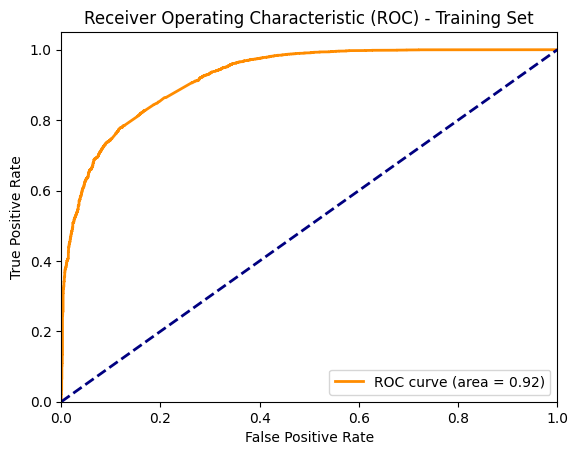

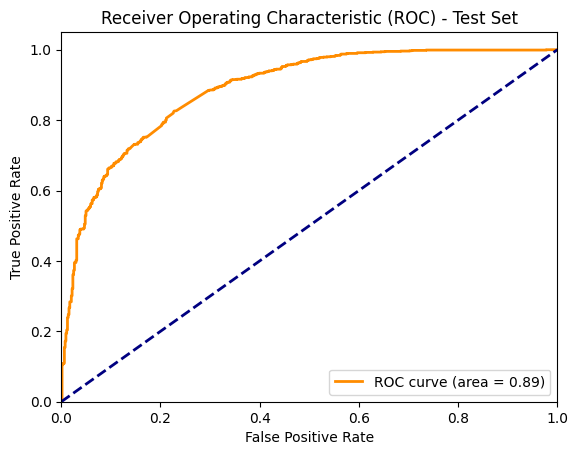

In [97]:
# Function to plot ROC Curve
def plot_roc_curve(y_true, y_pred_proba, set_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {set_name}')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC Curve for Training Set
plot_roc_curve(y_train, y_train_pred_proba, 'Training Set')

# Plot ROC Curve for Test Set
plot_roc_curve(y_test, y_test_pred_proba, 'Test Set')

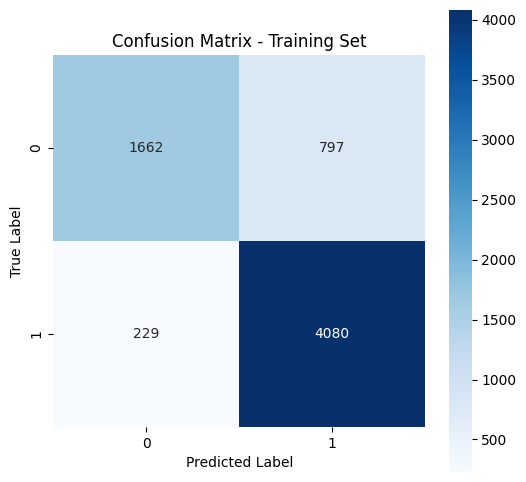

In [98]:
# Confusion Matrix for Training Set
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', square=True)
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

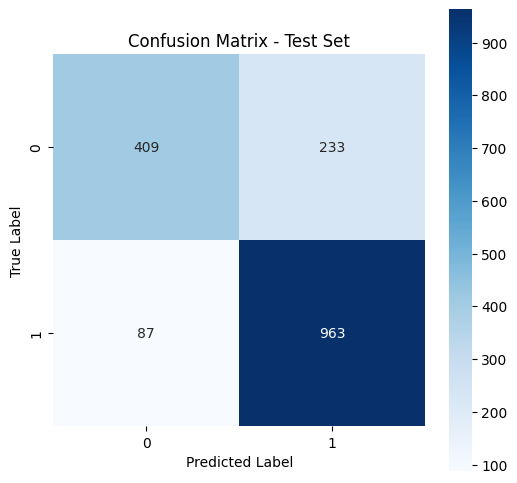

In [99]:
# Confusion Matrix for Test Set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', square=True)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Model Validation

In [100]:
# Define the k-fold cross-validator (e.g., k=5)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Apply k-fold cross-validation
scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

# Output the results
print(f"Accuracy scores for each fold are: {scores}")
print(f"Mean cross-validation accuracy: {np.mean(scores):.3f}")
print(f"Standard deviation of the accuracy across folds: {np.std(scores):.3f}")

[LightGBM] [Info] Number of positive: 4309, number of negative: 2459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 6768, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.636673 -> initscore=0.560951
[LightGBM] [Info] Start training from score 0.560951
[LightGBM] [Info] Number of positive: 4267, number of negative: 2501
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 6768, number of used features: 36
[LightGBM] [Info] [binary:Bo